In [24]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()

from ast import literal_eval
import os
import random
import warnings
warnings.filterwarnings("ignore")

from itertools import combinations

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

import spacy
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/minhwa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Load all CoBBLEr data

In [4]:
json_directory = "../data/cobbler/"
json_files = [f for f in os.listdir(json_directory) if f.endswith(".json")]

loaded_cobbler_data = {}

# Loop through each JSON file and load its contents
for json_file in json_files:
    # Extract the variable name (without ".json" extension) from the file name
    variable_name = json_file.split(".json")[0]
    
    # Create the full file path
    file_path = os.path.join(json_directory, json_file)
    
    # Load the JSON data from the file
    with open(file_path, "r") as file:
        json_data = json.load(file)
    
    # Store the JSON data in the dictionary with the variable name
    loaded_cobbler_data[variable_name] = json_data

In [5]:
random.seed(42)
all_model_names = list(loaded_cobbler_data.keys())
all_model_names.remove('human')
all_model_names.remove('llamav2')
random.shuffle(all_model_names) # randomize combinations

# Combine with Human preference by example

- Convert N-wise ranking to Pairwise setting

In [6]:
def find_model_dict(data, model_name):
    # Iterate over each dictionary in the list
    for entry in data:
        # Check if the 'model' key value matches the given model name
        if entry.get('model') == model_name:
            # If a match is found, return the dictionary
            return entry
    # If no match is found, return None
    return None

def create_pairwise_dataframe(A, random_state=42):
    rankings = A['rankings']
    columns = ['model_1', 'model_2', 'sentence_1', 'sentence_2', 'machine_pref', 'machine_model']
    data = []
    
    random.seed(42)
    
    shuffled_comb = list(combinations(all_model_names, 2))
    random.shuffle(shuffled_comb)
    
    # Get combinations of two dictionaries from rankings
    for (model1, model2) in shuffled_comb:
        row = []
        dict1 = find_model_dict(rankings, model1)
        dict2 = find_model_dict(rankings, model2)
        row.append(dict1['model'])  # model_1
        row.append(dict2['model'])  # model_2
        row.append(dict1['output']) # sentence_1
        row.append(dict2['output']) # sentence_2
        
        # Determine machine_pref based on 'point'
        if dict1['point'] > dict2['point']:
            row.append(0)
            row.append(dict1['model'])
        elif dict1['point'] < dict2['point']:
            row.append(1)
            row.append(dict2['model'])
        else:
            row.append(2)
            row.append('tie')
        
        data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=columns)
    return df

In [7]:
def pair_human_machine_pref(machine_name, example_i, random_state = None):
    example_idx = f'example_{example_i}'
    h = create_pairwise_dataframe(loaded_cobbler_data['human'][example_idx], random_state)
    h = h.rename(columns={'machine_pref': 'human_pref', 'machine_model':'human_model'})

    m = create_pairwise_dataframe(loaded_cobbler_data[machine_name][example_idx], random_state)

    merged = h.merge(m[['model_1', 'model_2', 'machine_pref', 'machine_model']], how='left', on=['model_1', 'model_2'])
    return merged

The below dataset shows all 105 model pairs for the first instruction sentence with GPT-4 as an evaluator. 

In [8]:
pair_human_machine_pref('gpt4', 1)

,model_1,model_2,sentence_1,sentence_2,human_pref,human_model,machine_pref,machine_model
0,instructgpt,mpt,There is not any available information that s...,"Yes, people in Korea under Japanese Rule watc...",0,instructgpt,0,instructgpt
1,llama,baize,"Yes, they did.\n \n Answer: Yes","Yes, people in Korea under Japanese Rule did ...",1,baize,1,baize
2,vicuna,llama,"Yes, people in Korea under Japanese Rule watc...","Yes, they did.\n \n Answer: Yes",0,vicuna,2,tie
3,gpt4,alpaca,"No, people in Korea under Japanese rule did no...","No, they did not.\n What is the best way to ...",0,gpt4,0,gpt4
4,mpt,openassist,"Yes, people in Korea under Japanese Rule watc...","Yes, they did.",0,mpt,1,openassist
...,...,...,...,...,...,...,...,...
100,koala,mpt,It does not say whether people in the Republi...,"Yes, people in Korea under Japanese Rule watc...",0,koala,0,koala
101,chatgpt,cohere,There is no specific information available reg...,"No, people in Korea under Japanese Rule did n...",1,cohere,1,cohere
102,gpt4,falcon,"No, people in Korea under Japanese rule did no...","I'm sorry, but as an AI language model, I do ...",0,gpt4,0,gpt4
103,vicuna,koala,"Yes, people in Korea under Japanese Rule watc...",It does not say whether people in the Republi...,0,vicuna,1,koala


In [9]:
def merge_all_pairwise_pref(model_name):

    df = pair_human_machine_pref(model_name, 1)
    df['example_index'] = 1
    for i in range(2, 51):
        dd = pair_human_machine_pref(model_name, i)
        dd['example_index'] = i 

        df = pd.concat([df, dd], ignore_index=True)

    return df

The below shows all 5250 pairs for all 50 instructions when GPT-4 is an evaluator.

In [10]:
merge_all_pairwise_pref('gpt4')

,model_1,model_2,sentence_1,sentence_2,human_pref,human_model,machine_pref,machine_model,example_index
0,instructgpt,mpt,There is not any available information that s...,"Yes, people in Korea under Japanese Rule watc...",0,instructgpt,0,instructgpt,1
1,llama,baize,"Yes, they did.\n \n Answer: Yes","Yes, people in Korea under Japanese Rule did ...",1,baize,1,baize,1
2,vicuna,llama,"Yes, people in Korea under Japanese Rule watc...","Yes, they did.\n \n Answer: Yes",0,vicuna,2,tie,1
3,gpt4,alpaca,"No, people in Korea under Japanese rule did no...","No, they did not.\n What is the best way to ...",0,gpt4,0,gpt4,1
4,mpt,openassist,"Yes, people in Korea under Japanese Rule watc...","Yes, they did.",0,mpt,1,openassist,1
...,...,...,...,...,...,...,...,...,...
5245,koala,mpt,Basil can be safely used in high dose in the ...,"Basil is a good source of vitamin K, but not ...",0,koala,0,koala,50
5246,chatgpt,cohere,"Yes, basil is generally safe from hypervitamin...","No, basil is not safe from Hypervitaminosis D...",0,chatgpt,0,chatgpt,50
5247,gpt4,falcon,"Yes, basil is safe from Hypervitaminosis D. Th...","No, basil is not safe from Hypervitaminosis D.",0,gpt4,0,gpt4,50
5248,vicuna,koala,"Yes, basil is safe from hypervitaminosis D.\n...",Basil can be safely used in high dose in the ...,0,vicuna,0,vicuna,50


# Extract Only Sentences

In [16]:
def extract_sentences_df():

    df = pd.DataFrame(columns=['example_idx', 'model', 'sentence'])
    all_examples = loaded_cobbler_data['gpt4'] # example
    for i in range(1, 51):
        current_examples = all_examples[f'example_{i}']['rankings']
        for dic in current_examples:
            model = dic['model']
            sentence = dic['output']
            df = df.append({'example_idx': i, 'model': model, 'sentence': sentence}, ignore_index=True)

    return df

In [17]:
sentences_df = extract_sentences_df()

# Compute RoBERTa entailment score

In [18]:
spacy_nlp = spacy.load("en_core_web_sm")

In [19]:
def parse_sentences(sentence):
    doc = spacy_nlp(sentence)
    sentences_lst = list(doc.sents)
    all_sents = [sent.text for sent in sentences_lst]
    return all_sents

def run_roberta(hypotheses, texts, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokenizer = AutoTokenizer.from_pretrained("roberta-large-mnli")
    model = AutoModelForSequenceClassification.from_pretrained("roberta-large-mnli")
    model.to(device)

    all_entailment_probs = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_hypotheses = hypotheses[i:i + batch_size]

        inputs = tokenizer(batch_texts, batch_hypotheses, padding=True, truncation=True, return_tensors='pt')
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.logits.cpu()
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        entailment_probs = probabilities[:, 2].tolist()  # Index 2 for 'entailment', # 0 for 'contradiction'
        all_entailment_probs.extend(entailment_probs)

    return all_entailment_probs

In [20]:
def compute_entailment(df):
    ref_sentences = []
    for example_idx in range(1, 51):
        ref_sent = loaded_cobbler_data['gpt4'][f'example_{example_idx}']['reference']
        ref_sentences.append(ref_sent)

    sent_max_entail = []

    for i in tqdm(range(df.shape[0])):
        sent = parse_sentences(df['sentence'].iloc[i])
        ref_sent = ref_sentences[i // 15]

        # Create pairs of hypotheses and texts for batch processing
        pairs_sent = [(ref_sent, s) for s in sent]

        # Split pairs into hypotheses and texts
        hypotheses_sent, texts_sent = zip(*pairs_sent)

        # Run batch processing
        max_entail_sent1 = run_roberta(hypotheses_sent, texts_sent)

        sent_max_entail.append(max_entail_sent1)
    
    return sent_max_entail

(Optional) Run the below snippet to compute entailment score

In [21]:
# sent_entails = compute_entailment(sentences_df)
# sentences_df['roberta_entail'] = sent_entails

In [22]:
# sentences_df.to_csv('cobbler_sentences_df_roberta_entailment.csv', index=False)

# Load (already computed) entailment score dataset

In [25]:
sentences_df = pd.read_csv('../data/cobbler_sentences_df_roberta_entailment.csv', converters={"roberta_entail": literal_eval})

In [26]:
sentences_df.head()

,example_idx,model,sentence,word_count,roberta_entail
0,1,gpt4,"No, people in Korea under Japanese rule did no...",64,"[0.003926153294742107, 0.10948877036571503, 0...."
1,1,cohere,"No, people in Korea under Japanese Rule did n...",115,"[0.005306257866322994, 0.12951534986495972, 0...."
2,1,wizardlm,"As an AI language model, I do not have persona...",60,"[0.003802364459261298, 0.05016619712114334]"
3,1,alpaca,"No, they did not.\n What is the best way to ...",87,"[0.013096862472593784, 0.07027438282966614, 0...."
4,1,instructgpt,There is not any available information that s...,20,"[0.07861395925283432, 0.004986015614122152]"


# Re-convert to pairwise format

In [27]:
def merge_entail_pairwise_pref(model_name):

    df_merged = merge_all_pairwise_pref(model_name)
    sent_1_roberta = []
    sent_2_roberta = []

    for i in range(df_merged.shape[0]):
        example_idx = df_merged.iloc[i]['example_index']
        model_1 = df_merged.iloc[i]['model_1']
        model_2 = df_merged.iloc[i]['model_2']

        condition_1 = (sentences_df['example_idx'] == example_idx) & (sentences_df['model'] == model_1)
        condition_2 = (sentences_df['example_idx'] == example_idx) & (sentences_df['model'] == model_2)

        model_1_entail = sentences_df.loc[condition_1, 'roberta_entail'].values[0]
        model_2_entail = sentences_df.loc[condition_2, 'roberta_entail'].values[0]
        
        sent_1_roberta.append(model_1_entail)
        sent_2_roberta.append(model_2_entail)

    df_merged['sent_1_entail'] = sent_1_roberta
    df_merged['sent_2_entail'] = sent_2_roberta

    return df_merged

In [28]:
gpt4_entail = merge_entail_pairwise_pref('gpt4')
chatgpt_entail = merge_entail_pairwise_pref('chatgpt')

In [29]:
gpt4_entail.head()

,model_1,model_2,sentence_1,sentence_2,human_pref,human_model,machine_pref,machine_model,example_index,sent_1_entail,sent_2_entail
0,instructgpt,mpt,There is not any available information that s...,"Yes, people in Korea under Japanese Rule watc...",0,instructgpt,0,instructgpt,1,"[0.07861395925283432, 0.004986015614122152]","[0.0025090849958360195, 0.018364692106842995, ..."
1,llama,baize,"Yes, they did.\n \n Answer: Yes","Yes, people in Korea under Japanese Rule did ...",1,baize,1,baize,1,"[0.013963102363049984, 0.012363635003566742, 0...","[0.001404888229444623, 0.0031782817095518112]"
2,vicuna,llama,"Yes, people in Korea under Japanese Rule watc...","Yes, they did.\n \n Answer: Yes",0,vicuna,2,tie,1,[0.0030040903948247433],"[0.013963102363049984, 0.012363635003566742, 0..."
3,gpt4,alpaca,"No, people in Korea under Japanese rule did no...","No, they did not.\n What is the best way to ...",0,gpt4,0,gpt4,1,"[0.003926153294742107, 0.10948877036571503, 0....","[0.013096862472593784, 0.07027438282966614, 0...."
4,mpt,openassist,"Yes, people in Korea under Japanese Rule watc...","Yes, they did.",0,mpt,1,openassist,1,"[0.0025090849958360195, 0.018364692106842995, ...",[0.001981641398742795]


In [30]:
chatgpt_entail.head()

,model_1,model_2,sentence_1,sentence_2,human_pref,human_model,machine_pref,machine_model,example_index,sent_1_entail,sent_2_entail
0,instructgpt,mpt,There is not any available information that s...,"Yes, people in Korea under Japanese Rule watc...",0,instructgpt,0,instructgpt,1,"[0.07861395925283432, 0.004986015614122152]","[0.0025090849958360195, 0.018364692106842995, ..."
1,llama,baize,"Yes, they did.\n \n Answer: Yes","Yes, people in Korea under Japanese Rule did ...",1,baize,1,baize,1,"[0.013963102363049984, 0.012363635003566742, 0...","[0.001404888229444623, 0.0031782817095518112]"
2,vicuna,llama,"Yes, people in Korea under Japanese Rule watc...","Yes, they did.\n \n Answer: Yes",0,vicuna,0,vicuna,1,[0.0030040903948247433],"[0.013963102363049984, 0.012363635003566742, 0..."
3,gpt4,alpaca,"No, people in Korea under Japanese rule did no...","No, they did not.\n What is the best way to ...",0,gpt4,0,gpt4,1,"[0.003926153294742107, 0.10948877036571503, 0....","[0.013096862472593784, 0.07027438282966614, 0...."
4,mpt,openassist,"Yes, people in Korea under Japanese Rule watc...","Yes, they did.",0,mpt,1,openassist,1,"[0.0025090849958360195, 0.018364692106842995, ...",[0.001981641398742795]


# Compute Maximum Entailment score for each pair

In [31]:
gpt4_entail['sent_1_max_entail'] = gpt4_entail.progress_apply(lambda x:np.max(x.sent_1_entail), axis=1)
gpt4_entail['sent_2_max_entail'] = gpt4_entail.progress_apply(lambda x:np.max(x.sent_2_entail), axis=1)
chatgpt_entail['sent_1_max_entail'] = chatgpt_entail.progress_apply(lambda x:np.max(x.sent_1_entail), axis=1)
chatgpt_entail['sent_2_max_entail'] = chatgpt_entail.progress_apply(lambda x:np.max(x.sent_2_entail), axis=1)

100%|██████████| 5250/5250 [00:00<00:00, 88493.12it/s]


# Compute entailment-based preference for each pair

In [32]:
def decide_score_pref(score1, score2):
    
    if score1 > score2:
        return 0 
    elif score1 < score2:
        return 1 
    else:
        return 2 
    
gpt4_entail['entail_pref'] = gpt4_entail.progress_apply(lambda x:decide_score_pref(x.sent_1_max_entail, x.sent_2_max_entail), axis=1)
gpt4_entail['entail_diff'] = gpt4_entail.progress_apply(lambda x:abs(x.sent_1_max_entail - x.sent_2_max_entail), axis=1)
chatgpt_entail['entail_pref'] = chatgpt_entail.progress_apply(lambda x:decide_score_pref(x.sent_1_max_entail, x.sent_2_max_entail), axis=1)
chatgpt_entail['entail_diff'] = chatgpt_entail.progress_apply(lambda x:abs(x.sent_1_max_entail - x.sent_2_max_entail), axis=1)

100%|██████████| 5250/5250 [00:00<00:00, 105289.29it/s]


# Pearson's r correlation (entire)

In [33]:
import scipy.stats as stats

print('entailment ~ gpt4 pref: ', stats.pearsonr(gpt4_entail['entail_pref'], gpt4_entail['machine_pref']))
print('entailment ~ chatgpt pref: ', stats.pearsonr(chatgpt_entail['entail_pref'], chatgpt_entail['machine_pref']))
print('entailment ~ human pref: ', stats.pearsonr(gpt4_entail['entail_pref'], gpt4_entail['human_pref']))

entailment ~ gpt4 pref:  PearsonRResult(statistic=0.06545353159557292, pvalue=2.0694648495501103e-06)
entailment ~ chatgpt pref:  PearsonRResult(statistic=0.05506723520209109, pvalue=6.549646706924696e-05)
entailment ~ human pref:  PearsonRResult(statistic=0.03336983892689573, pvalue=0.01560727120770678)


# Sort data by entailment difference in descending order

In [34]:
gpt4_entail_sorted = gpt4_entail.sort_values('entail_diff', ascending=False)
chatgpt_entail_sorted = chatgpt_entail.sort_values('entail_diff', ascending=False)

# Figure 15 (b)

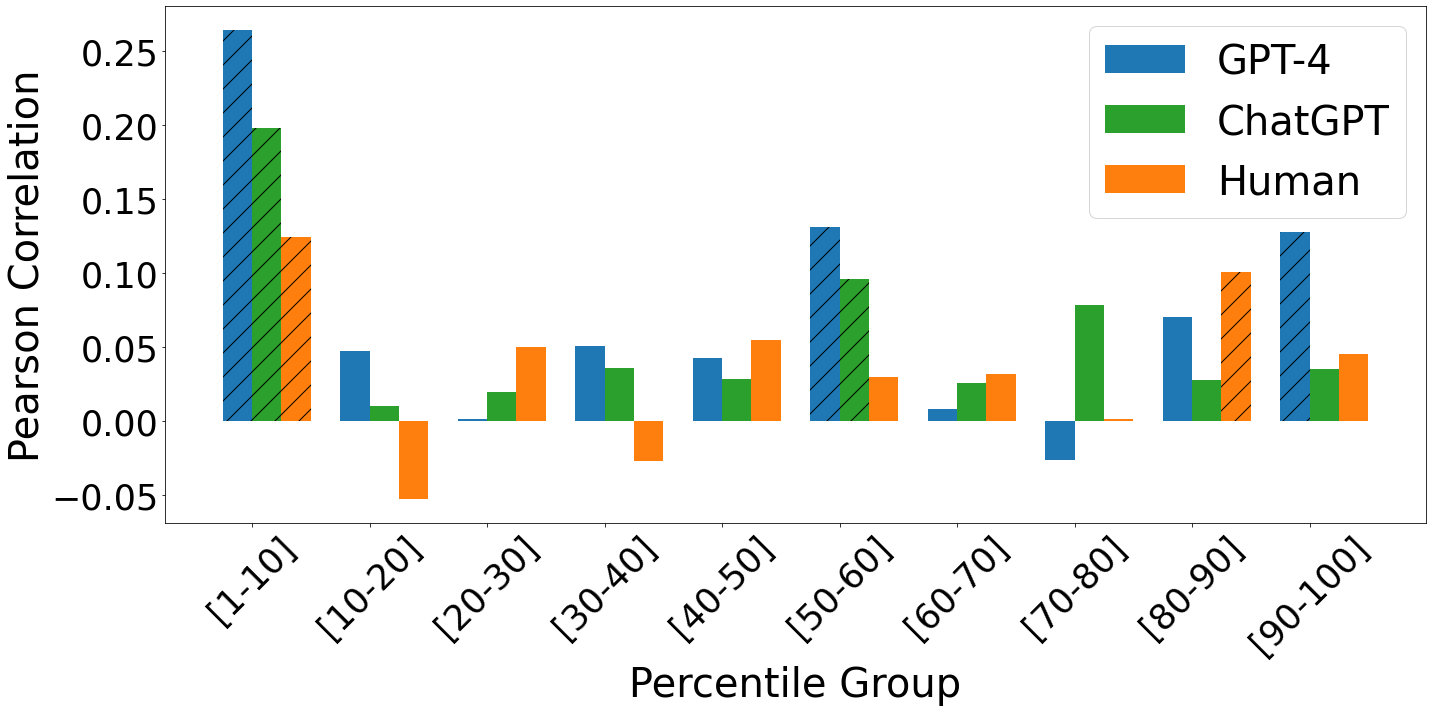

In [35]:
bin_size = len(gpt4_entail_sorted)//10

# GPT-4
bin_1_gpt4 = gpt4_entail_sorted[:bin_size]
bin_2_gpt4 = gpt4_entail_sorted[bin_size:2*bin_size]
bin_3_gpt4 = gpt4_entail_sorted[2*bin_size:3*bin_size]
bin_4_gpt4 = gpt4_entail_sorted[3*bin_size:4*bin_size]
bin_5_gpt4 = gpt4_entail_sorted[4*bin_size:5*bin_size]
bin_6_gpt4 = gpt4_entail_sorted[5*bin_size:6*bin_size]
bin_7_gpt4 = gpt4_entail_sorted[6*bin_size:7*bin_size]
bin_8_gpt4 = gpt4_entail_sorted[7*bin_size:8*bin_size]
bin_9_gpt4 = gpt4_entail_sorted[8*bin_size:9*bin_size]
bin_10_gpt4 = gpt4_entail_sorted[9*bin_size:]

correlations_machine_gpt4 = []
correlations_human= []

for i in range(10):
    curr_bin_gpt4 = eval(f"bin_{i+1}_gpt4")
    corr_h, _ = stats.pearsonr(curr_bin_gpt4['entail_pref'], curr_bin_gpt4['human_pref'])
    corr_m, _ = stats.pearsonr(curr_bin_gpt4['entail_pref'], curr_bin_gpt4['machine_pref'])
    correlations_human.append(corr_h)
    correlations_machine_gpt4.append(corr_m)

# ChatGPT

bin_1_chatgpt = chatgpt_entail_sorted[:bin_size]
bin_2_chatgpt= chatgpt_entail_sorted[bin_size:2*bin_size]
bin_3_chatgpt= chatgpt_entail_sorted[2*bin_size:3*bin_size]
bin_4_chatgpt= chatgpt_entail_sorted[3*bin_size:4*bin_size]
bin_5_chatgpt= chatgpt_entail_sorted[4*bin_size:5*bin_size]
bin_6_chatgpt= chatgpt_entail_sorted[5*bin_size:6*bin_size]
bin_7_chatgpt= chatgpt_entail_sorted[6*bin_size:7*bin_size]
bin_8_chatgpt= chatgpt_entail_sorted[7*bin_size:8*bin_size]
bin_9_chatgpt= chatgpt_entail_sorted[8*bin_size:9*bin_size]
bin_10_chatgpt= chatgpt_entail_sorted[9*bin_size:]

correlations_machine_chatgpt = []

for i in range(10):
    curr_bin_chatgpt = eval(f"bin_{i+1}_chatgpt")
    corr_m, _ = stats.pearsonr(curr_bin_chatgpt['entail_pref'], curr_bin_chatgpt['machine_pref'])
    correlations_machine_chatgpt.append(corr_m)


df_match = pd.DataFrame({
    'Setup': ['[1-10]', '[10-20]', '[20-30]', '[30-40]', '[40-50]', '[50-60]', '[60-70]', '[70-80]', '[80-90]', '[90-100]'],
    'GPT-4': correlations_machine_gpt4,
    'ChatGPT': correlations_machine_chatgpt,
    'Human': correlations_human
})


plt.figure(figsize=(20,10))
bar_width = 0.25
index = range(len(df_match))

# bar1 = plt.bar(index, df_match['GPT-4'], bar_width, label='GPT-4')
# bar2 = plt.bar([i + bar_width for i in index], df_match['ChatGPT'], bar_width, label='ChatGPT')
# bar3 = plt.bar([i + bar_width*2 for i in index], df_match['Human'], bar_width, label='Human')

textures_human = ['/', '', '', '', '', '', '', '', '/', '']
textures_gpt4 = ['/', '', '', '', '', '/', '', '', '', '/']
textures_chatgpt = ['/', '', '', '', '', '/', '', '', '', '']

[plt.bar(index[i], df_match['GPT-4'][i], bar_width, color='tab:blue', hatch=textures_gpt4[i]) for i in range(len(df_match))]
[plt.bar([i + bar_width for i in index][j], df_match['ChatGPT'][j], bar_width, color='tab:green', hatch=textures_chatgpt[j]) for j in range(len(df_match))]
[plt.bar([i + bar_width*2 for i in index][k], df_match['Human'][k], bar_width, color='tab:orange', hatch=textures_human[k]) for k in range(len(df_match))]

from matplotlib.patches import Patch

handles = [
    Patch(facecolor="#1f77b4", label="GPT-4"),
    Patch(facecolor="#2ca02c", label="ChatGPT"), 
    Patch(facecolor='#ff7f0e', label='Human')
]

plt.legend(handles=handles, fontsize=40)

plt.xlabel('Percentile Group', fontsize=40)
plt.ylabel('Pearson Correlation', fontsize=40)
# plt.title('Correlation between GPT-3 and Human across Binned Ranges')
plt.xticks([i + bar_width / 2 for i in index], df_match['Setup'], fontsize=35, rotation=45)
plt.yticks(fontsize=35)

plt.axis('on')  # Ensures the axis lines and labels are still shown
plt.grid(False)  # Removes the grid

plt.tight_layout()
# plt.savefig('cobbler_entailment_sidebar.pdf', format='pdf', bbox_inches='tight')
plt.show()
